# Head change

Recognizing variety -> recognizing disease

We will change the head of the model. The defualt model predicts the type of diseases, but we are also given the type of rice as well. We assume that we can predict the type of disease better if we can use information about the variety of rice. This may sound counterintuitive because the model has to predict both disease and variety, but may do better. 

In [1]:
import os
from copy import copy, deepcopy
# os.environ
from fastai.vision.all import *
from fastcore.parallel import *
path = Path()
trn_path = path/'train_images'

In [2]:
path.ls()

(#11) [Path('paddy small models.ipynb'),Path('sample_submission.csv'),Path('test_images'),Path('paddy2.ipynb'),Path('train_images'),Path('paddy.ipynb'),Path('.ipynb_checkpoints'),Path('train.csv'),Path('subm.csv'),Path('changing head.ipynb')...]

In [3]:
df = pd.read_csv('train.csv')
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [4]:
df.variety.value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [27]:
dls = ImageDataLoaders.from_folder(
    trn_path, 
    valid_pct=0.2, 
    seed=42,
    item_tfms=Resize(224),
    # batch_tfms=aug_transforms(size=128, min_scale=0.75)
)
learn = vision_learner(dls, resnet34, metrics=error_rate)
deepcopy(learn)

## Changing the head

In [9]:
# Grab a model
m = learn.model

In [10]:
# h = m[1]
# ll = h[-1]
# del(h[-1])

Time to create a new layer for the head.

In [22]:
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.l1 = nn.Linear(512, 10, bias=False) # variety of rice
        self.l2 = nn.Linear(512, 10, bias=False) # type of disease
        del(m[1][-1])
        self.m = m
    
    def forward(self, x):
        x = self.m(x)
        x1 = self.l1(x)
        x2 = self.l2(x)
        return x1, x2

We created a new model. Let's copy a learner

In [44]:
dtc = DiseaseAndTypeClassifier(m)
learn2 = deepcopy(learn)
# Not trying this yet
# learn2.model = dtc

learn2.get_preds(dl=learn2.dls.valid) # returns probability and targets

(TensorBase([[2.1209e-07, 5.3692e-06, 2.1209e-07,  ..., 1.7854e-05,
              3.3275e-07, 2.1209e-07],
             [2.1123e-05, 1.7505e-03, 1.9627e-05,  ..., 8.1178e-04,
              5.6115e-05, 1.9627e-05],
             [1.1356e-05, 1.3998e-03, 9.7128e-06,  ..., 4.7895e-05,
              6.3788e-06, 6.3788e-06],
             ...,
             [6.6587e-07, 7.1107e-04, 6.6587e-07,  ..., 6.5450e-05,
              6.6587e-07, 6.6587e-07],
             [1.6502e-07, 4.1802e-06, 1.6502e-07,  ..., 5.0457e-06,
              1.6502e-07, 1.6502e-07],
             [6.8573e-07, 1.9268e-03, 6.8573e-07,  ..., 1.2502e-04,
              6.8573e-07, 6.8573e-07]]),
 tensor([4, 0, 5,  ..., 2, 3, 7]))

### Dummy classifier for testing.

In [47]:
class DummyClassifier(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    
    def forward(self, x):
        x = self.m(x)
        return x

In [48]:
dc = DummyClassifier(m)
learn2 = deepcopy(learn)
learn2.model = dc
learn2.get_preds(dl=learn2.dls.valid) # returns probability and targets

(TensorBase([[2.1209e-07, 5.3692e-06, 2.1209e-07,  ..., 1.7854e-05,
              3.3275e-07, 2.1209e-07],
             [2.1123e-05, 1.7505e-03, 1.9627e-05,  ..., 8.1178e-04,
              5.6115e-05, 1.9627e-05],
             [1.1356e-05, 1.3998e-03, 9.7128e-06,  ..., 4.7895e-05,
              6.3788e-06, 6.3788e-06],
             ...,
             [6.6587e-07, 7.1107e-04, 6.6587e-07,  ..., 6.5450e-05,
              6.6587e-07, 6.6587e-07],
             [1.6502e-07, 4.1802e-06, 1.6502e-07,  ..., 5.0457e-06,
              1.6502e-07, 1.6502e-07],
             [6.8573e-07, 1.9268e-03, 6.8573e-07,  ..., 1.2502e-04,
              6.8573e-07, 6.8573e-07]]),
 tensor([4, 0, 5,  ..., 2, 3, 7]))

### Dummy head works, so let's try our thing to work. So, we need a loss function.

In [23]:
curr_loss_func = learn.loss_func

In [24]:
def dtc_loss(preds, targs):
    """Just trying to make our model work with the new structure."""
    rice_pred, disease_pred = preds
    return curr_loss_func(disease_pred, targs)

In [25]:
def dtc_metrics(preds, targs):
    """Just trying to make our model work with the new structure."""
    rice_pred, disease_pred = preds
    return error_rate(disease_pred, targs)

In [28]:
dtc = DiseaseAndTypeClassifier(m)
learn2 = deepcopy(learn)
learn2.model = dtc
learn2.loss_func = dtc_loss 
# learn2.metrics = None  # We do not have a metrics that works yet
learn2.metrics = [dtc_metrics]

# learn2.get_preds(dl=learn2.dls.valid) # returns probability and targets

SuggestedLRs(valley=0.0008317637839354575)

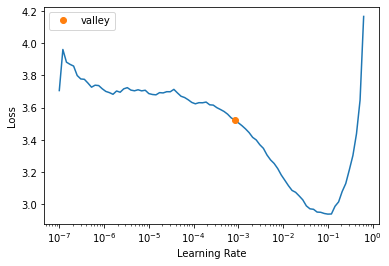

In [29]:
learn.lr_find()

In [30]:
learn2.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,dtc_metrics,time
0,2.497433,2.430557,0.890918,01:03


epoch,train_loss,valid_loss,dtc_metrics,time
0,2.488581,2.430304,0.890437,01:03
1,2.507527,2.427459,0.890918,01:03
2,2.502759,2.430322,0.887074,01:03


In [32]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.976934,1.085664,0.345026,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.839950,0.470263,0.146084,01:29
1,0.379459,0.274309,0.076886,01:29
2,0.156593,0.227549,0.065834,01:29
